c:\Users\adi\miniconda3\envs\smart_hans\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


smart_hans_07252022_154259_11_395-432_08_mgy_.csv
smart_hans_07252022_154619_12_431-469_08_mgy_.csv
smart_hans_07252022_155048_13_482-523_08_mny_.csv
smart_hans_07252022_155230_11_402-439_08_mgy_.csv
smart_hans_07312022_160010_5_109-124_08_mny_x.csv
smart_hans_07312022_161226_7_250-280_08_mgy_.csv
smart_hans_07312022_161925_10_313-339_08_mny_.csv
smart_hans_07312022_162132_5_146-170_08_mny_.csv
smart_hans_07312022_162305_9_246-269_08_mny_.csv
smart_hans_07312022_162745_8_272-303_08_mgy_.csv
smart_hans_07312022_164319_11_363-393_08_mny_.csv
smart_hans_07312022_164533_9_305-333_08_mgy_.csv
smart_hans_07312022_164702_5_181-209_08_mgy_.csv
smart_hans_07312022_164838_8_276-305_08_mgy_klatschen_8_ende.csv
smart_hans_07312022_165851_12_402-433_08_mgy_.csv
smart_hans_07312022_170052_6_215-244_08_mgy_.csv
smart_hans_07312022_170216_4_149-178_08_mgy_furz_lachen_am_ende.csv
smart_hans_07312022_170549_7_197-222_08_mnn_.csv
smart_hans_07312022_171246_5_174-198_08_mnn_.csv
smart_hans_07312022_171406

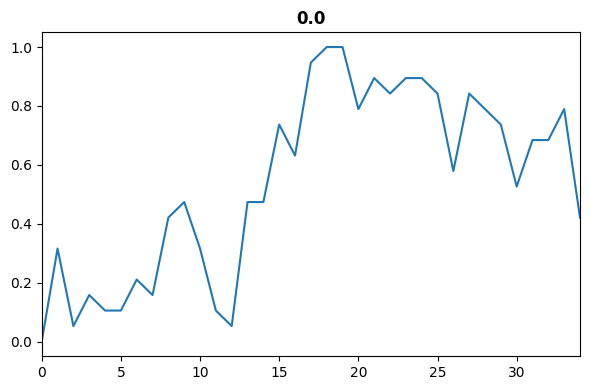

In [1]:
from tsai.all import *
import pandas as pd
from datenverarbeitung.dataloader import dataloader
import datetime
CUDA_LAUNCH_BLOCKING=1



num_scenario = 3
nr_taps = 1
window_size = 35
move_by = 10
model_to_use = "InceptionTime"
batch_size = 1 
learning_cycles = 7
features_to_learn_with = ["right_eye_y"]
feature_list_string = '_'.join(features_to_learn_with)

models_folder = "models"
plots_folder = "vis/plots"
save_name = "scenario_{}_{}".format(num_scenario, model_to_use)

dl = dataloader(scenario= num_scenario, path="E:\local_hansi\smart_hans\AP2\Daten\zum_sichten\laeuft", nr_taps=nr_taps, move_window_by=move_by, tap_size=35, feature_list=["right_eye_corner_x"])
train, test= dl.train, dl.test

X_test, y_test = df2xy(test, target_col='target')
X_train, y_train = df2xy(train, target_col='target')

X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=1, batch_tfms=[], num_workers=0)

dls.show_batch(sharey=True)

In [2]:

scenario_name_stage0 = save_name+"_nr_taps_{}_features_{}".format(str(nr_taps), feature_list_string)+"_stage0"
model = InceptionTime(dls.vars, dls.c)
learn = ts_learner(dls, model, metrics=accuracy, train_metrics=True, lr=0.001)
learn.save(scenario_name_stage0)

Path('models/scenario_3_InceptionTime_nr_taps_1_features_right_eye_y_stage0.pth')

In [3]:
#learn.load(scenario_name_stage0)
#learn.lr_find()

In [4]:
scenario_name_stage1 = scenario_name_stage0.replace("0","1")
learn.fit_one_cycle(learning_cycles, lr_max=1e-3)
learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.697203,0.512690,0.795604,0.482353,00:02
1,0.725661,0.527919,0.687399,0.505882,00:02
2,0.687380,0.507614,0.936801,0.482353,00:02
3,0.705901,0.522843,0.735428,0.494118,00:02
4,0.697804,0.538071,0.695208,0.505882,00:02
5,0.667072,0.619289,0.695083,0.517647,00:02
6,0.636966,0.685279,0.698317,0.564706,00:02


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


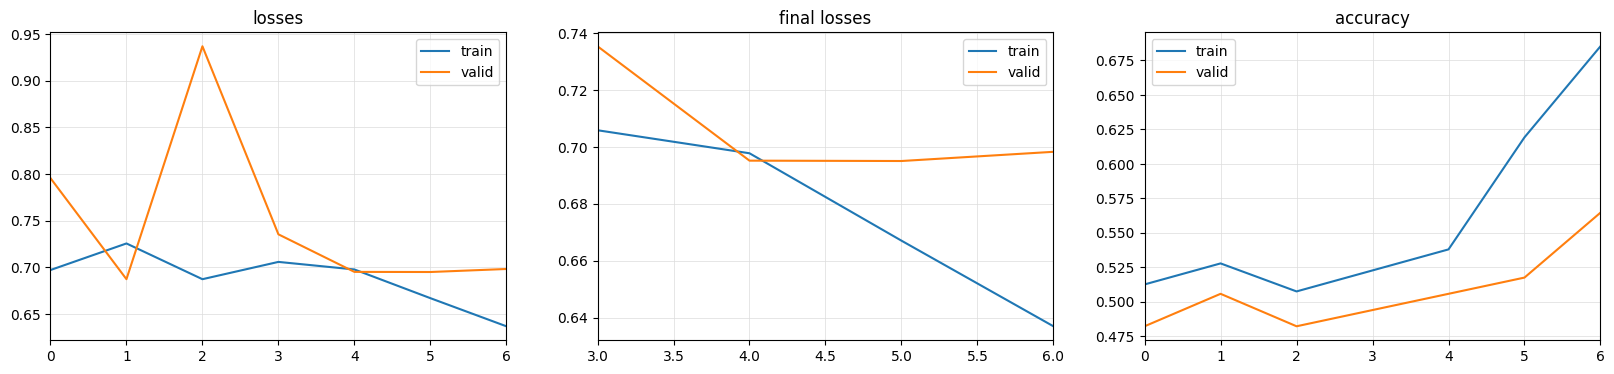

TypeError: got an unexpected keyword argument 'ext'

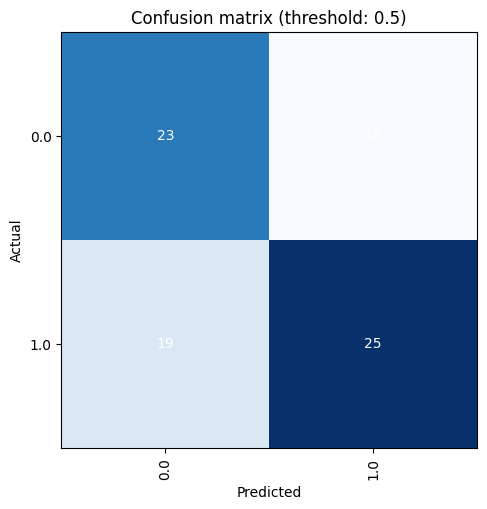

In [5]:
learn.recorder.plot_metrics()
learn.plot_confusion_matrix()
feature_list_string = '_'.join(features_to_learn_with)
current_time= datetime.datetime.now().strftime('%d%m%Y_%H%M%S')
plot_name = plots_folder+"/confusion_matrix_"+save_name+"_nrtaps_{}_features_{}_learning_cycles_{}_{}.png".format(str(nr_taps),feature_list_string,learning_cycles, current_time)
plt.savefig(plot_name, ext='png', bbox_inches="tight")

In [ ]:
learn.show_results()

In [ ]:
learn.show_probas()
#was sagt probability aus? accuracy vs probability?